In [76]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection and Pre-Processing

In [55]:
twitter_data = pd.read_csv('dataset/bot_detection_data.csv')

In [56]:
# First 5 rows
twitter_data.head()

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [57]:
# Number of rows and columns
twitter_data.shape

(50000, 11)

In [58]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


Only the Hastags columns has some missing values.

In [59]:
twitter_data.describe(include='all')

,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
count,50000.000000,50000,50000,50000.00000,50000.000000,50000.000000,50000,50000.000000,50000,50000,41659
unique,NaN,40566,50000,NaN,NaN,NaN,2,NaN,25199,49989,34247
top,NaN,ksmith,Station activity person against natural majori...,NaN,NaN,NaN,True,NaN,South Michael,2021-02-07 06:50:00,area
freq,NaN,21,1,NaN,NaN,NaN,25004,NaN,44,2,21
mean,548890.680540,NaN,NaN,50.00560,2.513760,4988.602380,NaN,0.500360,NaN,NaN,NaN
std,259756.681425,NaN,NaN,29.18116,1.708563,2878.742898,NaN,0.500005,NaN,NaN,NaN
min,100025.000000,NaN,NaN,0.00000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,323524.250000,NaN,NaN,25.00000,1.000000,2487.750000,NaN,0.000000,NaN,NaN,NaN
50%,548147.000000,NaN,NaN,50.00000,3.000000,4991.500000,NaN,1.000000,NaN,NaN,NaN
75%,772983.000000,NaN,NaN,75.00000,4.000000,7471.000000,NaN,1.000000,NaN,NaN,NaN


**We will be performing the following steps:**
- We will exclude the 'UserID' and 'Location' columns from our analysis. The 'UserID' is a unique identifier that is unlikely to provide useful predictive information. As for 'Location', we are aiming to build a predictive model that is as general as possible, and we don't want the model's predictions to be influenced by location data.
- We will also exclude the 'Username' column, but not before we extract two features from it. The first feature will indicate whether the username contains any numbers, and the second feature will represent the length of the username.
- For the 'Created At' column, we will extract the time of day when each tweet was created. This could provide useful information about whether bots are more active at certain times of day.
- The remaining columns will be processed and prepared for use in a neural network model. This will involve steps such as normalizing numerical data and encoding categorical data.

In [60]:
# Dropping the User ID and Location columns
twitter_data.drop(columns=['User ID', 'Location'], axis=1, inplace=True)

In [61]:
twitter_data.head()

,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Created At,Hashtags
0,flong,Station activity person against natural majori...,85,1,2353,False,1,2020-05-11 15:29:50,NaN
1,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,2022-11-26 05:18:10,both live
2,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,2022-08-08 03:16:54,phone ahead
3,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,2021-08-14 22:27:05,ever quickly new I
4,noah87,Animal sign six data good or.,26,3,8438,False,1,2020-04-13 21:24:21,foreign mention


In [62]:
# Checking numbers in Username
def contains_digits(username):
    return bool(re.search(r'\d', username))

In [63]:
# Creating new column checking for numbers in username
twitter_data['Numbers in Username'] = twitter_data['Username'].apply(contains_digits)

In [64]:
# Creating new column with the username length
twitter_data['Username Length'] = twitter_data['Username'].str.len()

In [65]:
# Checking the new columns
twitter_data.head()

,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Created At,Hashtags,Numbers in Username,Username Length
0,flong,Station activity person against natural majori...,85,1,2353,False,1,2020-05-11 15:29:50,NaN,False,5
1,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,2022-11-26 05:18:10,both live,False,14
2,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,2022-08-08 03:16:54,phone ahead,False,10
3,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,2021-08-14 22:27:05,ever quickly new I,False,6
4,noah87,Animal sign six data good or.,26,3,8438,False,1,2020-04-13 21:24:21,foreign mention,True,6


In [66]:
# Removing the Username column
twitter_data.drop(columns=['Username'], axis=1, inplace=True)

In [67]:
# Getting the time of the day represented as decimal from Created At

# Converting the Created At column from Object to Datetime
twitter_data['Created At'] = pd.to_datetime(twitter_data['Created At'])

# Extract the hour of the day and minute of the hour
hours = twitter_data['Created At'].dt.hour
minutes = twitter_data['Created At'].dt.minute

# Creating new column with decimals representation
twitter_data['Time of Day'] = hours + minutes / 60


In [69]:
# Removing the Created At column
twitter_data.drop(columns=['Created At'], axis=1, inplace=True)

In [72]:
# Reordering the columns
twitter_data = twitter_data[['Numbers in Username', 'Username Length', 'Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Time of Day', 'Hashtags', 'Bot Label']].copy()

In [73]:
twitter_data.head()

,Numbers in Username,Username Length,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Time of Day,Hashtags,Bot Label
0,False,5,Station activity person against natural majori...,85,1,2353,False,15.483333,NaN,1
1,False,14,Authority research natural life material staff...,55,5,9617,True,5.300000,both live,0
2,False,10,Manage whose quickly especially foot none to g...,6,2,4363,True,3.266667,phone ahead,0
3,False,6,Just cover eight opportunity strong policy which.,54,5,2242,True,22.450000,ever quickly new I,1
4,True,6,Animal sign six data good or.,26,3,8438,False,21.400000,foreign mention,1


## Exploratory Analysis

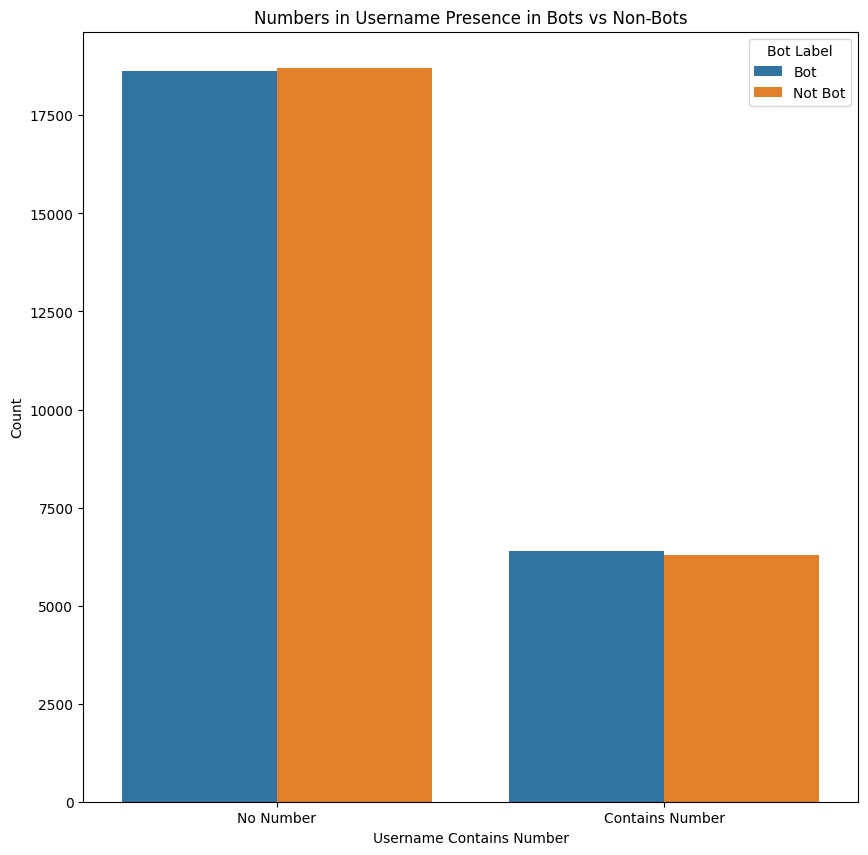

In [84]:
# Create a temporary DataFrame for visualization
df_temp = twitter_data.copy()
df_temp['Numbers in Username'] = df_temp['Numbers in Username'].map({True: 'Contains Number', False: 'No Number'})
df_temp['Bot Label'] = df_temp['Bot Label'].map({1: 'Bot', 0: 'Not Bot'})

plt.figure(figsize=(10, 10))
sns.countplot(x='Numbers in Username', hue='Bot Label', data=df_temp)
plt.title('Numbers in Username Presence in Bots vs Non-Bots')
plt.xlabel('Username Contains Number')
plt.ylabel('Count')
plt.show()

In the distribution of bot and non-bot accounts in relation to the presence of numbers in their usernames, we observe a roughly equal proportion across both categories. This suggests that the feature 'Numbers in Username' may not significantly differentiate between bot and non-bot accounts. Consequently, we anticipate that this feature may not contribute much to the model.